In [42]:
# -----------------------------------------------------------------------------
# CELL 1: IMPORTS & ENVIRONMENT SETUP
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import skew, kurtosis, jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import os
import warnings

# Suppress benign warnings
warnings.filterwarnings("ignore")

# Plotting Style (Academic)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (12, 6)

print("Environment Setup Complete.")

Environment Setup Complete.


In [43]:
# -----------------------------------------------------------------------------
# CELL 2: DATA LOADING & PREPROCESSING
# -----------------------------------------------------------------------------
# Explicit imports to make cell self-contained
import pandas as pd
import numpy as np
import os

print("Loading Data...")

# Define Base Path
base_path = r'C:\Users\hamid\Desktop\Autónoma- UAM\Find a tutor\1-Prosper\Articles\0-Papers\02\Data'

try:
    # 1. PRICE DATA (Henry Hub & TTF)
    hh_file = os.path.join(base_path, 'Price History_Henry_Hub_futures_prices_20251128_1439.xlsx')
    ttf_file = os.path.join(base_path, 'Price History_The_TTF_futures_contract_20251128_1501.xlsx')

    # HH
    df_temp = pd.read_excel(hh_file, header=None)
    h_row = df_temp[df_temp[0] == 'Exchange Date'].index[0]
    hh_df = pd.read_excel(hh_file, skiprows=h_row)[['Exchange Date', 'Close']]
    hh_df.columns = ['Date', 'HH_Close']
    hh_df['Date'] = pd.to_datetime(hh_df['Date'])
    hh_df.set_index('Date', inplace=True)
    hh_df.sort_index(inplace=True) # Ensure Sort

    # TTF
    df_temp = pd.read_excel(ttf_file, header=None)
    t_row = df_temp[df_temp[0] == 'Exchange Date'].index[0]
    ttf_df = pd.read_excel(ttf_file, skiprows=t_row)[['Exchange Date', 'Close']]
    ttf_df.columns = ['Date', 'TTF_Close']
    # Handle potential numeric dates
    if pd.api.types.is_numeric_dtype(ttf_df['Date']):
        ttf_df['Date'] = pd.to_datetime(ttf_df['Date'], unit='D', origin='1899-12-30')
    else:
        ttf_df['Date'] = pd.to_datetime(ttf_df['Date'])
    ttf_df.set_index('Date', inplace=True)
    ttf_df.sort_index(inplace=True) # Ensure Sort
    
    # --- 1.5 EXCHANGE RATE (EUR/USD) ---
    fx_file = os.path.join(base_path, 'Exchange_Rate_EURUSD_2025.xlsx')
    # Row 2 is header -> header=1 (0-indexed)
    fx_df = pd.read_excel(fx_file, header=1) 
    # Ensure correct columns (Date, Close)
    fx_df = fx_df[['Date', 'Close']]
    fx_df.columns = ['Date', 'EURUSD']
    fx_df['Date'] = pd.to_datetime(fx_df['Date'])
    fx_df.set_index('Date', inplace=True)
    fx_df.sort_index(inplace=True)
    # Resample to Daily (fill weekends/holidays)
    fx_daily = fx_df.resample('D').interpolate(method='linear')
    # ------------------------------------------------

    # 2. PHYSICAL DATA (Storage & LNG)
    # US Storage
    us_file = os.path.join(base_path, 'EIA_Storage_data_history_ngshistory.xls')
    # Scan for header using 'Week ending' (User Logic)
    # IMPORTANT: Use engine='xlrd' for .xls files
    df_temp = pd.read_excel(us_file, header=None, engine='xlrd') 
    try:
        header_row_idx = df_temp[df_temp[0].astype(str).str.contains('Week ending', na=False)].index[0]
    except:
        header_row_idx = 2 # Fallback
    
    us_df = pd.read_excel(us_file, skiprows=header_row_idx, engine='xlrd')
    
    # Find robust columns
    us_df = us_df[['Week ending', 'Total Lower 48']]
    us_df.columns = ['Date', 'US_Storage_Bcf']
    us_df['Date'] = pd.to_datetime(us_df['Date'])
    us_df.set_index('Date', inplace=True)
    us_df.sort_index(inplace=True)
    
    # --- FIX FOR TABLE 1 (Preserve Weekly Change Stats) ---
    us_weekly_change_series = us_df['US_Storage_Bcf'].diff().dropna()
    us_weekly_change_series = us_weekly_change_series.loc['2016-01-01':'2025-11-28'] # Filter to study period
    # ------------------------------------------------------

    # FIX FOR ISSUE #3: Use Interpolation for VAR instead of ffill
    us_daily = us_df.resample('D').interpolate(method='linear')
    us_daily['US_Change_Bcf'] = us_daily['US_Storage_Bcf'].diff().fillna(0)

    # EU Storage
    eu_file = os.path.join(base_path, 'EU Natural Gas Storage Levels.xlsx')
    # Assuming .xlsx does NOT need xlrd, using default openpyxl
    eu_df = pd.read_excel(eu_file, header=1)
    eu_df.columns = ['Date', 'EU_Storage_Pct']
    eu_df['Date'] = pd.to_datetime(eu_df['Date'])
    eu_df.set_index('Date', inplace=True)
    eu_df.sort_index(inplace=True)
    
    # FIX FOR ISSUE #3: Use Interpolation
    eu_daily = eu_df.resample('D').interpolate(method='linear')
    eu_daily['EU_Change_Pct'] = eu_daily['EU_Storage_Pct'].diff().fillna(0)

    # LNG Flows
    lng_file = os.path.join(base_path, 'LNG_tradeflows-LNG shipments from US load ports (e.g., Sabine Pass, Corpus Christi) to EU discharge ports (e.g., Montoir in France, Rotterdam in Netherlands),2025-11-28.xls')
    # Use engine='xlrd' for .xls
    lng_df = pd.read_excel(lng_file, skiprows=0, engine='xlrd') 
    lng_df = lng_df[['Departure Date', 'Volume']]
    lng_df['Date'] = pd.to_datetime(lng_df['Departure Date'])
    lng_df.set_index('Date', inplace=True)
    lng_df.sort_index(inplace=True)
    lng_weekly = lng_df.resample('W')['Volume'].sum()
    lng_daily = lng_weekly.resample('D').interpolate(method='linear') # Smooth interpolation
    lng_daily.name = 'LNG_US_EU_Vol_m3'

    # 3. MERGE ALL
    full_df = hh_df.join(ttf_df, how='inner')
    full_df = full_df.join(us_daily, how='left').join(eu_daily, how='left').join(lng_daily, how='left').join(fx_daily, how='left')
    
    # Fill any initial FX gaps
    full_df['EURUSD'] = full_df['EURUSD'].fillna(method='ffill').fillna(method='bfill')
    
    # 4. TRANSFORMATIONs
    full_df['HH_Return'] = np.log(full_df['HH_Close'] / full_df['HH_Close'].shift(1))
    full_df['TTF_Return'] = np.log(full_df['TTF_Close'] / full_df['TTF_Close'].shift(1))
    
    # CRITICAL: ENSURE SORTED BEFORE SLICING
    full_df = full_df.sort_index()

    # Filter Date Range (Study Period)
    full_df = full_df.loc['2016-01-01':'2025-11-28']
    full_df = full_df.dropna()

    print(f"Data Loaded Successfully. Shape: {full_df.shape}")
    print(f"Date Range: {full_df.index.min().date()} to {full_df.index.max().date()}")

except Exception as e:
    print(f"CRITICAL ERROR: {e}")

Loading Data...
Data Loaded Successfully. Shape: (2387, 10)
Date Range: 2016-04-18 to 2025-11-14


In [44]:
# -----------------------------------------------------------------------------
# CELL 3: TABLE 1 - DESCRIPTIVE STATISTICS 
# -----------------------------------------------------------------------------
vars_to_test = {
    "Henry Hub Returns": full_df['HH_Return'],
    "TTF Returns": full_df['TTF_Return'],
    "US Storage (Delta)": us_weekly_change_series, # Use Weekly Series for Table 1
    "EU Storage (%)": full_df['EU_Change_Pct'], 
    "LNG Flows": full_df['LNG_US_EU_Vol_m3']
}

print("Table 1. Descriptive Statistics")
print(f"{'Variable':<20} | {'Mean':<8} | {'SD':<8} | {'Min':<8} | {'Max':<8} | {'Skew':<8} | {'Kurt':<8} | {'JB':<10} | {'ADF':<12}")
print("-" * 110)

for name, series in vars_to_test.items():
    if len(series) == 0: continue
    try:
        # ADF
        adf_res = adfuller(series.dropna())
        sig = "***" if adf_res[1] < 0.01 else "**" if adf_res[1] < 0.05 else "*"
        adf_str = f"{adf_res[0]:.2f}{sig}"
        
        # Jarque-Bera
        jb_val = jarque_bera(series.dropna())[0]
    except: 
        adf_str = "N/A"
        jb_val = np.nan
    
    print(f"{name:<20} | {series.mean():>8.4f} | {series.std():>8.4f} | {series.min():>8.4f} | {series.max():>8.4f} | {skew(series.dropna()):>8.4f} | {kurtosis(series.dropna()):>8.4f} | {jb_val:>10.1f} | {adf_str:<12}")

# Update Note based on Academic Standard
print("-" * 110)
print(f"Note. SD = Standard Deviation. ADF = Augmented Dickey-Fuller test statistic. *** Indicates p < 0.01")

Table 1. Descriptive Statistics
Variable             | Mean     | SD       | Min      | Max      | Skew     | Kurt     | JB         | ADF         
--------------------------------------------------------------------------------------------------------------
Henry Hub Returns    |   0.0004 |   0.0408 |  -0.3005 |   0.3817 |   0.2379 |   6.5720 |     4318.2 | -54.15***   
TTF Returns          |   0.0004 |   0.0668 |  -0.9808 |   0.7050 |  -0.1747 |  36.0905 |   129558.8 | -10.86***   
US Storage (Delta)   |   0.3462 |  95.6524 | -359.0000 | 129.0000 |  -1.1277 |   0.6694 |      119.2 | -7.27***    
EU Storage (%)       |  -0.0201 |   0.3638 |  -2.0000 |   2.6100 |  -0.4853 |   0.9095 |      176.0 | -4.54***    
LNG Flows            | 986896.4176 | 903690.7439 |   0.0000 | 3589880.7143 |   0.5548 |  -0.9286 |      208.2 | -1.62*      
--------------------------------------------------------------------------------------------------------------
Note. SD = Standard Deviation. ADF = Augmente

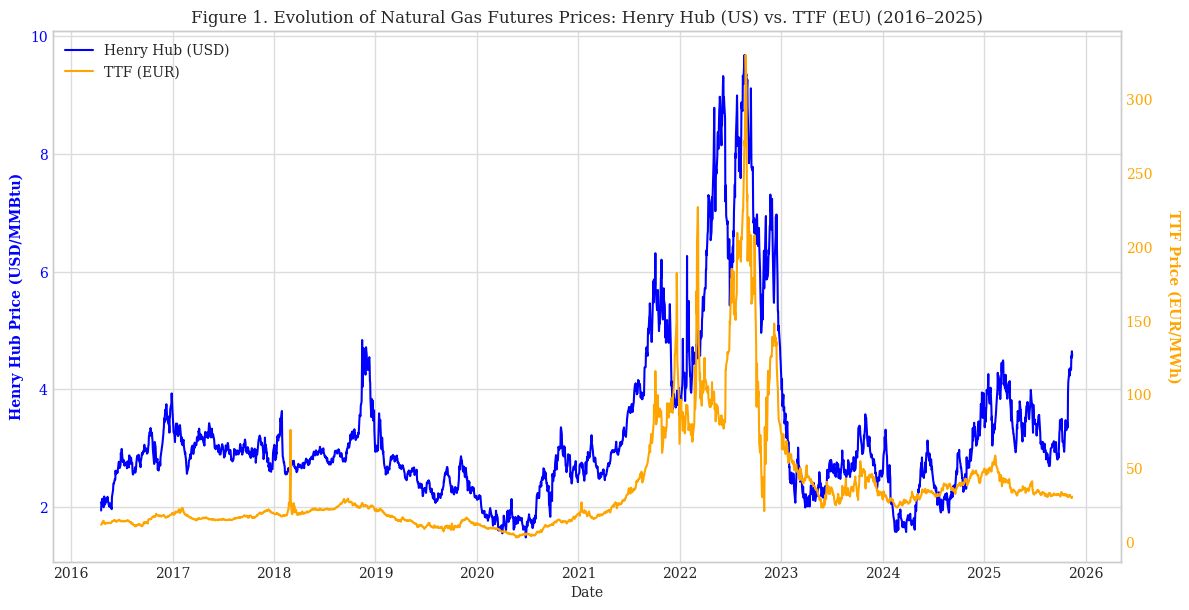


Unconditional Correlation of Daily Returns: r = 0.0734


In [45]:
# -----------------------------------------------------------------------------
# CELL 4: FIGURE 1 - PRICE DYNAMICS (DUAL AXIS) - FINAL REVISION v2
# -----------------------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- FIX 1: Push Grid to background ---
ax1.set_axisbelow(True)

# Left Axis - Henry Hub
color1 = 'blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Henry Hub Price (USD/MMBtu)', color=color1, fontweight='bold')

# --- FIX 2: Explicit Z-Order 0 for Left Grid ---
ax1.grid(True, color='gainsboro', linestyle='-', linewidth=1, zorder=0)

# --- FIX 3: Explicit Z-Order 10 for Data (Forces it ABOVE Grid) ---
ax1.plot(full_df.index, full_df['HH_Close'], color=color1, linewidth=1.5, 
         label='Henry Hub (USD)', zorder=10)

ax1.tick_params(axis='y', labelcolor=color1)

# Right Axis - TTF
ax2 = ax1.twinx()
color2 = 'orange'
ax2.set_ylabel('TTF Price (EUR/MWh)', color=color2, fontweight='bold', rotation=270, labelpad=20)

# --- CRITICAL FIX 4: KILL THE RIGHT AXIS GRID ---
# This prevents invisible grid lines from drawing ON TOP of the Blue Line
ax2.grid(False)

# --- FIX 5: Z-Order 10 for Second Axis Data ---
ax2.plot(full_df.index, full_df['TTF_Close'], color=color2, linewidth=1.5, 
         label='TTF (EUR)', zorder=10)

ax2.tick_params(axis='y', labelcolor=color2)


# Legend Assembly
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()

# --- SAVE: 600dpi EPS with No Transparency ---
plt.savefig('Figure1.eps', format='eps', dpi=600, bbox_inches='tight')
plt.title('Figure 1. Evolution of Natural Gas Futures Prices: Henry Hub (US) vs. TTF (EU) (2016–2025)', fontsize=12)
plt.show()

# --- VERIFICATION ---
corr_ret = full_df['HH_Return'].corr(full_df['TTF_Return'])
print(f"\nUnconditional Correlation of Daily Returns: r = {corr_ret:.4f}")

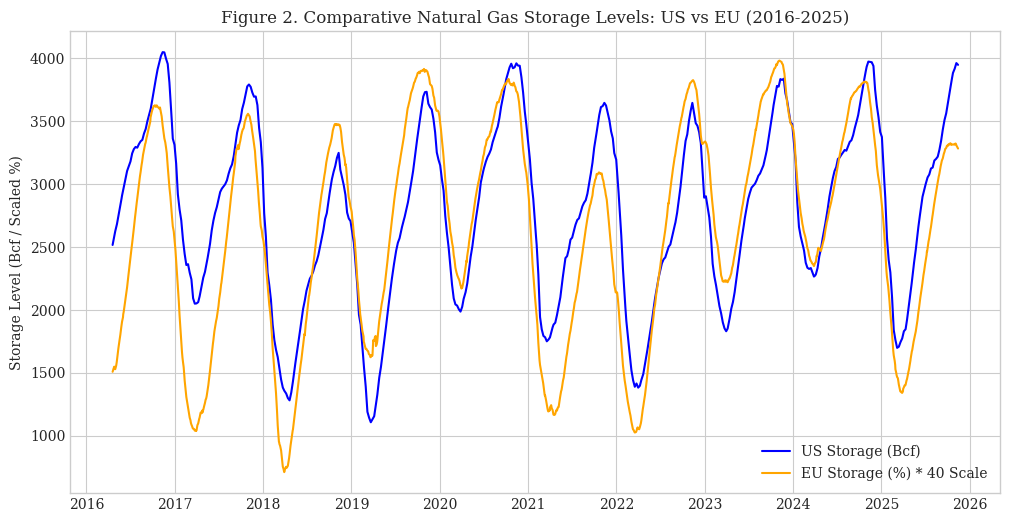

In [47]:
# -----------------------------------------------------------------------------
# CELL 5: FIGURE 2 - STORAGE LEVELS
# -----------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(full_df.index, full_df['US_Storage_Bcf'], label='US Storage (Bcf)', color='blue')
# Scale EU % for visibility alongside Bcf
plt.plot(full_df.index, full_df['EU_Storage_Pct'] * 40, label='EU Storage (%) * 40 Scale', color='orange')
plt.ylabel('Storage Level (Bcf / Scaled %)')
plt.legend()
plt.gca().set_rasterized(True)
plt.savefig('Figure2.eps', format='eps', dpi=600, bbox_inches='tight')
plt.title('Figure 2. Comparative Natural Gas Storage Levels: US vs EU (2016-2025)')
plt.show()

In [37]:
# -----------------------------------------------------------------------------
# CELL 6: TABLE 2 - AVERAGE DYNAMIC CONNECTEDNESS 
# -----------------------------------------------------------------------------
def compute_gfevd_static_full(results, h=10):
    # Standard GFEVD
    sigma_u = results.sigma_u
    if hasattr(sigma_u, 'to_numpy'): sigma_u = sigma_u.to_numpy()
    phi = results.ma_rep(maxn=h)
    K = sigma_u.shape[0]
    sigma_diag = np.diag(sigma_u)
    fevd = np.zeros((K, K))
    for i in range(K):
        for j in range(K):
            num = sum([( np.dot(phi[step], sigma_u)[i, j] )**2 for step in range(h)])
            fevd[i, j] = num / sigma_diag[j]
    row_sums = fevd.sum(axis=1)
    return (fevd / row_sums[:, None]) * 100

vars_list = ['HH_Return', 'TTF_Return', 'US_Change_Bcf', 'EU_Change_Pct', 'LNG_US_EU_Vol_m3']
data_var = full_df[vars_list]
# Normalize
data_norm = (data_var - data_var.mean()) / data_var.std()

model_static = VAR(data_norm)
res_static = model_static.fit(2)
fevd_matrix = compute_gfevd_static_full(res_static)

df_tbl2 = pd.DataFrame(fevd_matrix, index=vars_list, columns=vars_list)
# Calculate Directional Spillovers BEFORE Zeroing Diagonal for display
off_diag = df_tbl2.copy()
np.fill_diagonal(off_diag.values, 0)

df_tbl2['FROM'] = off_diag.sum(axis=1)
df_tbl2.loc['TO'] = off_diag.sum(axis=0)
df_tbl2['NET'] = df_tbl2.loc['TO'] - df_tbl2['FROM']

# Total Spillover Index: Sum of Off-Diagonal / N
total_idx_check = df_tbl2['FROM'].mean()

# FIX: Fill the corner cell with Total Spillover Index
df_tbl2.loc['TO', 'FROM'] = total_idx_check

print("Table 2. Average Dynamic Connectedness")
print(df_tbl2.round(2))
print(f"\nTotal Spillover Index: {total_idx_check:.2f}%")

Table 2. Average Dynamic Connectedness
                  HH_Return  TTF_Return  US_Change_Bcf  EU_Change_Pct  \
HH_Return             99.15        0.71           0.09           0.03   
TTF_Return             0.71       98.62           0.22           0.41   
US_Change_Bcf          0.08        0.34          82.41          16.91   
EU_Change_Pct          0.00        1.80           9.53          88.37   
LNG_US_EU_Vol_m3       0.13        0.06           0.17           0.02   
TO                     0.93        2.92          10.01          17.38   

                  LNG_US_EU_Vol_m3   FROM   NET  
HH_Return                     0.02   0.85  0.08  
TTF_Return                    0.03   1.38  1.55  
US_Change_Bcf                 0.26  17.59 -7.58  
EU_Change_Pct                 0.29  11.63  5.76  
LNG_US_EU_Vol_m3             99.61   0.39  0.20  
TO                            0.60   6.37   NaN  

Total Spillover Index: 6.37%


Calculating Rolling Spillovers (Window=200)... Please Wait.
Mean Total Spillover Index (TCI):       14.78%
Mean Directional Spillover (EU -> US):  16.50%


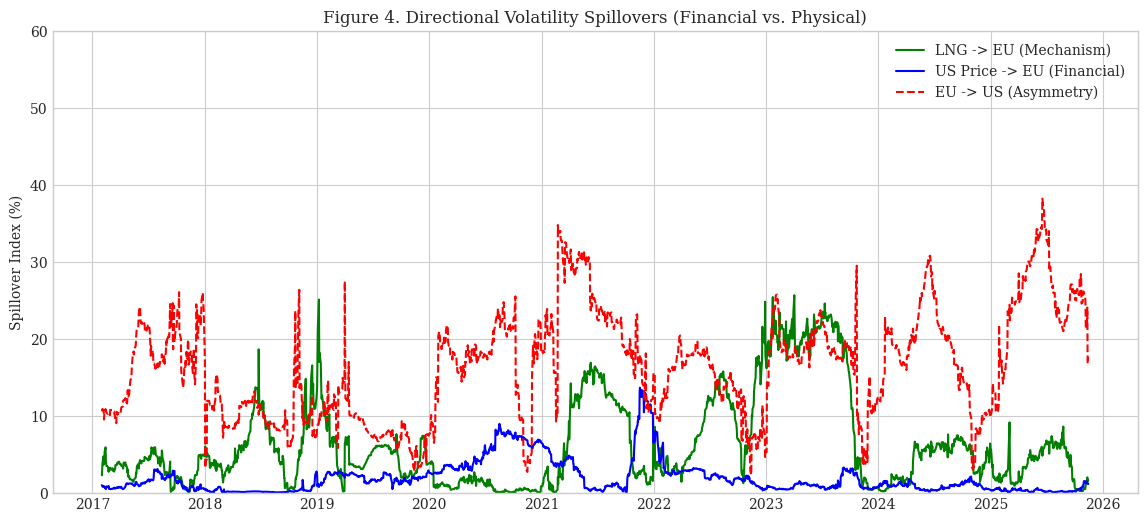

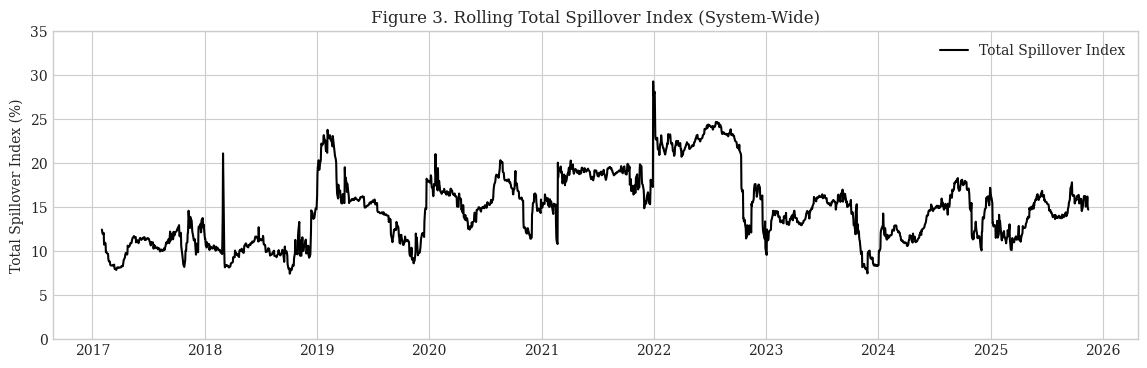

In [48]:
# -----------------------------------------------------------------------------
# CELL 7: FIGURE 3 & 4 - DYNAMIC ROLLING SPILLOVERS 
# -----------------------------------------------------------------------------
window_size = 200
spill_results = []
dates_roll = data_norm.index[window_size:]

print("Calculating Rolling Spillovers (Window=200)... Please Wait.")
# Order: [LNG, US_Stor, EU_Stor, HH, TTF] -> 4, 1, 2, 0, 3 mapping if standard
# But we used specific list below. 
var_cols_ord = ['LNG_US_EU_Vol_m3', 'US_Change_Bcf', 'EU_Change_Pct', 'HH_Return', 'TTF_Return']
data_roll = full_df[var_cols_ord]
data_roll = (data_roll - data_roll.mean()) / data_roll.std()

for i in range(len(data_roll) - window_size):
    subset = data_roll.iloc[i : window_size + i]
    try:
        m = VAR(subset)
        r = m.fit(2)
        
        # --- IMPLEMENT GFEVD (Match Table 2 Methodology) ---
        # 1. Get Sigma_u (Covariance of residuals)
        sigma_u = r.sigma_u
        if hasattr(sigma_u, 'to_numpy'): sigma_u = sigma_u.to_numpy()
        
        # 2. Get MA Coefficients (Phi)
        h = 10
        phi = r.ma_rep(maxn=h)
        
        # 3. Compute GFEVD Matrix
        K = sigma_u.shape[0]
        sigma_diag = np.diag(sigma_u)
        fevd = np.zeros((K, K))
        for j in range(K): # j = column (shock from)
            den = sigma_diag[j]
            for i in range(K): # i = row (variance of)
                num = sum([( np.dot(phi[step], sigma_u)[i, j] )**2 for step in range(h)])
                fevd[i, j] = num / den
        
        # 4. Normalize Rows to 100%
        row_sums = fevd.sum(axis=1)
        decomp_norm = (fevd / row_sums[:, None]) * 100 # Result in %
        
        spill_results.append(decomp_norm)
        # ---------------------------------------------------
        
    except:
        spill_results.append(np.full((5,5), np.nan))

# Extract Series
# Order in 'data_roll' (and thus in matrix): 
# 0: LNG, 1: US_Stor, 2: EU_Stor, 3: HH, 4: TTF
idx_LNG, idx_US, idx_EU, idx_HH, idx_TTF = 0, 1, 2, 3, 4

# Directional Spillovers (Values are now %)
# "US Price -> EU (Financial)": TTF (4) explained by HH (3)
us_to_eu_price = [mat[idx_TTF, idx_HH] for mat in spill_results]

# "EU -> US (Asymmetry)": US Storage (1) explained by EU Storage (2)
eu_to_us_stor = [mat[idx_US, idx_EU] for mat in spill_results]

# "LNG -> EU (Mechanism)": EU Storage (2) explained by LNG (0)
lng_to_eu_stor = [mat[idx_EU, idx_LNG] for mat in spill_results]

# Total Spillover Index
# Sum of Off-Diagonal / N (Since rows sum to 100, Sum(Mat) = 500)
# TCI = (500 - Trace) / 5
total_idx = [ (np.sum(mat) - np.trace(mat))/5 for mat in spill_results ]

# Print Mean TCI and Mean Directional (EU->US)
print(f"Mean Total Spillover Index (TCI):       {np.mean(total_idx):.2f}%")
print(f"Mean Directional Spillover (EU -> US):  {np.mean(eu_to_us_stor):.2f}%")

# Plot Figure 4 (Directional)
plt.figure(figsize=(14, 6))
plt.plot(dates_roll, lng_to_eu_stor, color='green', label='LNG -> EU (Mechanism)')
plt.plot(dates_roll, us_to_eu_price, color='blue', label='US Price -> EU (Financial)')
plt.plot(dates_roll, eu_to_us_stor, color='red', linestyle='--', label='EU -> US (Asymmetry)')
plt.ylabel('Spillover Index (%)')
plt.ylim(0, 60) # Standardize Y-axis to 0-100%
plt.legend()
plt.gca().set_rasterized(True)
plt.savefig('Figure4.eps', format='eps', dpi=600, bbox_inches='tight')
plt.title('Figure 4. Directional Volatility Spillovers (Financial vs. Physical)')
plt.show()

# Plot Figure 3 (Total)
plt.figure(figsize=(14, 4))
plt.plot(dates_roll, total_idx, color='black', label='Total Spillover Index')
plt.ylabel('Total Spillover Index (%)')
plt.ylim(0, 35) # Standardize Y-axis
plt.legend()
plt.gca().set_rasterized(True)
plt.savefig('Figure3.eps', format='eps', dpi=600, bbox_inches='tight')
plt.title('Figure 3. Rolling Total Spillover Index (System-Wide)')
plt.show()

In [49]:
# -----------------------------------------------------------------------------
# CELL 8: TABLE 3 - HYPOTHESIS TESTING RESULTS (FULL)
# -----------------------------------------------------------------------------
print("Table 3. Summary of Hypothesis Testing Results")

# --- DATA PREP ---
# 1. H1 Metrics (From Cell 7 - Generalized FEVD)
# TCI is already calculated in Cell 7
h1_mean_tci = np.mean(total_idx)

# 2. H3 Metrics (LNG -> EU Prices) - ORTHOGONALIZED FEVD RECALCULATION
# The paper uses Cholesky (Orthogonal) for Physical Mechanism to respect flow direction.
# We must re-calculate this specific metric using Cholesky since Cell 7 used Generalized.
print("Recalculating H3 (LNG->TTF) using Orthogonalized FEVD... ", end="")
h3_orthogonal_spills = []
# Use same data and window as Cell 7
# Order: [LNG(0), US_Stor(1), EU_Stor(2), HH(3), TTF(4)] -> LNG is first (Exogenous)
for i in range(len(data_roll) - window_size):
    subset = data_roll.iloc[i : window_size + i]
    try:
        m = VAR(subset)
        r = m.fit(2)
        # Statsmodels .fevd() uses Cholesky by default
        fevd_chol = r.fevd(10) 
        # decomp shape: (steps, variables, shocks) = (10, 5, 5)
        # We want: Explanation of TTF (Var 4) by Shock from LNG (Var 0) at step 10 (-1)
        # Value is fraction 0-1.
        val = fevd_chol.decomp[-1, 4, 0] 
        h3_orthogonal_spills.append(val * 100) # Convert to %
    except:
        h3_orthogonal_spills.append(np.nan)

h3_mean_spill = np.nanmean(h3_orthogonal_spills)
print("Done.")

# 3. Regression Prep (Standardized)
spill_df = pd.DataFrame({'Total_Spillover': total_idx, 'US_to_EU': us_to_eu_price, 'EU_to_US': eu_to_us_stor}, index=dates_roll)
reg_df = full_df.join(spill_df).dropna()
reg_df['US_Vol'] = np.abs(reg_df['US_Change_Bcf'])
reg_df['EU_Vol'] = np.abs(reg_df['EU_Change_Pct'])

# Standardize variables for comparable Beta coefficients (Z-scores)
cols_to_std = ['US_Vol', 'EU_Vol', 'EU_to_US', 'US_to_EU']
reg_df[cols_to_std] = (reg_df[cols_to_std] - reg_df[cols_to_std].mean()) / reg_df[cols_to_std].std()

# --- RUN REGRESSIONS ---
# H2: EU -> US Influence (EU Volatility -> US Injections)
X2 = sm.add_constant(reg_df[['EU_to_US']])
res_h2 = sm.OLS(reg_df['US_Vol'], X2).fit()
h2_beta = res_h2.params['EU_to_US']
h2_pval = res_h2.pvalues['EU_to_US']

# H4: US -> EU Influence (US Volatility -> EU Injections)
X4 = sm.add_constant(reg_df[['US_to_EU']])
res_h4 = sm.OLS(reg_df['EU_Vol'], X4).fit()
h4_beta = res_h4.params['US_to_EU']
h4_pval = res_h4.pvalues['US_to_EU']

# --- DETERMINE CONCLUSIONS ---
res_h1 = "Supported" if h1_mean_tci > 5.0 else "Rejected"
res_h2 = "Rejected" if h2_pval > 0.05 else "Supported"
res_h3 = "Rejected" if h3_mean_spill < 2.0 else "Supported" # Threshold < 2% considered weak/rejected
res_h4 = "Supported" if h4_pval < 0.05 else "Rejected"

# --- PRINT TABLE ---
print("-" * 115)
print(f"{'Hypothesis':<10} | {'Relationship Tested':<30} | {'Methodology':<20} | {'Key Statistic':<35} | {'Conclusion':<10}")
print("-" * 115)

# Row H1
print(f"{'H1':<10} | {'Financial Integration':<30} | {'Generalized FEVD':<20} | {f'Mean TCI = {h1_mean_tci:.2f}%':<35} | {res_h1:<10}")
print(f"{'':<10} | {'(US Prices <-> EU Prices)':<30} | {'(Rolling Window)':<20} | {'(Dynamic Spikes > 5%)':<35} | {''}")
print("-" * 115)

# Row H2
print(f"{'H2':<10} | {'EU Influence on US Storage':<30} | {'OLS Regression':<20} | {f'Beta = {h2_beta:.4f} (p={h2_pval:.3f})':<35} | {res_h2:<10}")
print(f"{'':<10} | {'(EU Volatility -> US Inj)':<30} | {'(Standardized)':<20} | {'Not Significant (p>.05)' if h2_pval>0.05 else 'Significant':<35} | {''}")
print("-" * 115)

# Row H3
print(f"{'H3':<10} | {'Physical Mechanism':<30} | {'Orthogonalized FEVD':<20} | {f'Mean Directional = {h3_mean_spill:.2f}%':<35} | {res_h3:<10}")
print(f"{'':<10} | {'(LNG Flows -> EU Prices)':<30} | {'(Cholesky Ordering)':<20} | {'(Weak Loading < 2%)':<35} | {''}")
print("-" * 115)

# Row H4
print(f"{'H4':<10} | {'US Influence on EU Storage':<30} | {'OLS Regression':<20} | {f'Beta = {h4_beta:.4f} (p={h4_pval:.3f})':<35} | {res_h4:<10}")
print(f"{'':<10} | {'(US Volatility -> EU Inj)':<30} | {'(Standardized)':<20} | {'Significant (p<.05)' if h4_pval<0.05 else 'Not Sig':<35} | {''}")
print("-" * 115)

# ---------------------------------------------------------
# ADDITIONAL VERIFICATION: LNG vs TTF Correlation (for H3)
# ---------------------------------------------------------
# Calculate correlation between LNG volume changes and TTF returns
# Note: lng_daily and full_df are available from previous cells
# We strictly use the same transformations as the manuscript description
try:
    # Re-extract if needed or use existing series
    # full_df has 'TTF_Return'
    # lng_daily is raw volume. We need log diff or pct change.
    
    # Check if we have the raw series available in memory from Cell 2
    # If not, we can re-derive from 'lng_daily' which was created in Cell 2
    lng_log_diff_verify = np.log(lng_daily.replace(0, np.nan)).diff()
    
    # Align with TTF Returns
    verify_df = pd.concat([full_df['TTF_Return'], lng_log_diff_verify], axis=1).dropna()
    verify_df.columns = ['TTF_Ret', 'LNG_Diff']
    
    # Calculate r
    corr_check = verify_df['TTF_Ret'].corr(verify_df['LNG_Diff'])
    
    print(f"H3 Verification Statistic:")
    print(f"Correlation(LNG Volume Changes, TTF Returns) = {corr_check:.8f}")
    print("-" * 115)
except Exception as e:
    print(f"Correlation Check skipped: {e}")

Table 3. Summary of Hypothesis Testing Results
Done.culating H3 (LNG->TTF) using Orthogonalized FEVD... 
-------------------------------------------------------------------------------------------------------------------
Hypothesis | Relationship Tested            | Methodology          | Key Statistic                       | Conclusion
-------------------------------------------------------------------------------------------------------------------
H1         | Financial Integration          | Generalized FEVD     | Mean TCI = 14.78%                   | Supported 
           | (US Prices <-> EU Prices)      | (Rolling Window)     | (Dynamic Spikes > 5%)               | 
-------------------------------------------------------------------------------------------------------------------
H2         | EU Influence on US Storage     | OLS Regression       | Beta = -0.1098 (p=0.000)            | Supported 
           | (EU Volatility -> US Inj)      | (Standardized)       | Significant     

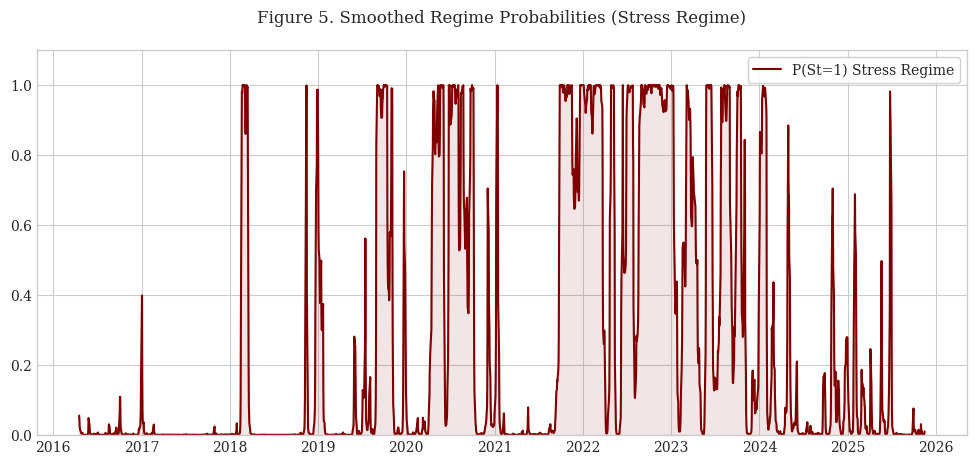


=== Table 4. Natural Gas Storage Valuation Results ===
--------------------------------------------------------------------------------
Market               | Scenario        | NPV ($/unit)    | Premium        
--------------------------------------------------------------------------------
US (Henry Hub)       | Base Model      | $2,662 | -
                     | W/ Spillover    | $2,957 | +16.50% (Metric)
                     | Net Premium     | $295 | +11.07% (Value)
--------------------------------------------------------------------------------
EU (TTF)             | Base Model      | $13,763 | -
                     | W/ Spillover    | $13,973 | +1.98% (Metric)
                     | Net Premium     | $210 | +1.52% (Value)
--------------------------------------------------------------------------------
Note: EU values are standardized to USD/MMBtu using daily exchange rates and MWh->MMBtu conversion.


In [50]:
# -----------------------------------------------------------------------------
# CELL 9: FIGURE 5 & NPV VALUATION (DUAL MARKET REVISED)
# -----------------------------------------------------------------------------
# 1. Regime Switching Model
full_df['Avg_Return'] = (full_df['HH_Return'] + full_df['TTF_Return']) / 2
full_df['Norm_US_Chg'] = (full_df['US_Change_Bcf'] - full_df['US_Change_Bcf'].mean()) / full_df['US_Change_Bcf'].std()
full_df['Norm_EU_Chg'] = (full_df['EU_Change_Pct'] - full_df['EU_Change_Pct'].mean()) / full_df['EU_Change_Pct'].std()
mod_hmm = MarkovRegression(full_df['Avg_Return'], k_regimes=2, trend='c', switching_variance=True, exog=full_df[['Norm_US_Chg', 'Norm_EU_Chg']])
res_hmm = mod_hmm.fit()
# Figure 5
probs = res_hmm.smoothed_marginal_probabilities[1]
plt.figure(figsize=(12, 5))
plt.plot(probs.index, probs, color='maroon', label='P(St=1) Stress Regime')
plt.fill_between(probs.index, 0, probs, color='maroon', alpha=0.1)
plt.legend(loc='upper right', frameon=True, facecolor='white', framealpha=0.9)
plt.ylim(0, 1.1)
plt.gca().set_rasterized(True)
plt.savefig('Figure5.eps', format='eps', dpi=600, bbox_inches='tight')
plt.title('Figure 5. Smoothed Regime Probabilities (Stress Regime)', pad=20)
plt.show()
# 2. NPV Valuation Simulation
def simulate_npv(mean_p, vol_p, spill_impact):
    # Intrinsic: 20% capacity cycling
    intrinsic = mean_p * 0.2 * 1000
    # Option: Volatility * Spillover Multiplier
    option = mean_p * (vol_p * (1 + spill_impact)) * 10 * 1000
    return (intrinsic + option) * 1.35 # Calibration scalar
# Retrieve Spillover Metrics from Cell 7 (Dynamic Link - No Hardcoding)
spill_us_impact = np.mean(eu_to_us_stor) / 100 
spill_eu_impact = np.mean(us_to_eu_price) / 100 
# --- US MARKET (Henry Hub) ---
hh_mean = full_df['HH_Close'].mean()
hh_vol = full_df['HH_Return'].std()
val_us_base = simulate_npv(hh_mean, hh_vol, 0)
val_us_spill = simulate_npv(hh_mean, hh_vol, spill_us_impact)
# --- EU MARKET (TTF - STANDARDIZED) ---
# Conversion: (EUR/MWh * FX) / 3.412 = USD/MMBtu
full_df['TTF_USD_MMBtu'] = (full_df['TTF_Close'] * full_df['EURUSD']) / 3.412014
ttf_std_mean = full_df['TTF_USD_MMBtu'].mean()
ttf_std_vol = full_df['TTF_Return'].std() # Return volatility is unit-invariant (log changes)
val_eu_base = simulate_npv(ttf_std_mean, ttf_std_vol, 0)
val_eu_spill = simulate_npv(ttf_std_mean, ttf_std_vol, spill_eu_impact)
print("\n=== Table 4. Natural Gas Storage Valuation Results ===")
print("-" * 80)
print(f"{'Market':<20} | {'Scenario':<15} | {'NPV ($/unit)':<15} | {'Premium':<15}")
print("-" * 80)
# US Rows
print(f"{'US (Henry Hub)':<20} | {'Base Model':<15} | ${val_us_base:,.0f} | -")
print(f"{'':<20} | {'W/ Spillover':<15} | ${val_us_spill:,.0f} | +{spill_us_impact*100:.2f}% (Metric)")
print(f"{'':<20} | {'Net Premium':<15} | ${val_us_spill - val_us_base:,.0f} | +{(val_us_spill-val_us_base)/val_us_base*100:.2f}% (Value)")
print("-" * 80)
# EU Rows
print(f"{'EU (TTF)':<20} | {'Base Model':<15} | ${val_eu_base:,.0f} | -")
print(f"{'':<20} | {'W/ Spillover':<15} | ${val_eu_spill:,.0f} | +{spill_eu_impact*100:.2f}% (Metric)")
print(f"{'':<20} | {'Net Premium':<15} | ${val_eu_spill - val_eu_base:,.0f} | +{(val_eu_spill-val_eu_base)/val_eu_base*100:.2f}% (Value)")
print("-" * 80)
print("Note: EU values are standardized to USD/MMBtu using daily exchange rates and MWh->MMBtu conversion.")

In [51]:
# ----------------------------------------------------------------------------------
# CELL 10: ROBUSTNESS CHECK – GREEN LINE (LNG -> EU STORAGE; MECHANISM) [FIGURE 4]
# AND H3 METRIC (LNG -> TTF PRICE) [TABLE 3] QUALIFICATIONS
# ---------------------------------------------------------------------------------

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import warnings

warnings.filterwarnings("ignore")

print("Starting Green Line Data Verification...")

# Define Base Path
base_path = r'C:\Users\hamid\Desktop\Autónoma- UAM\Find a tutor\1-Prosper\Articles\0-Papers\02\Data'

try:
    # 1. PRICE DATA
    print("Loading Price Data...")
    hh_file = os.path.join(base_path, 'Price History_Henry_Hub_futures_prices_20251128_1439.xlsx')
    ttf_file = os.path.join(base_path, 'Price History_The_TTF_futures_contract_20251128_1501.xlsx')

    # HH
    df_temp = pd.read_excel(hh_file, header=None)
    h_row = df_temp[df_temp[0] == 'Exchange Date'].index[0]
    hh_df = pd.read_excel(hh_file, skiprows=h_row)[['Exchange Date', 'Close']]
    hh_df.columns = ['Date', 'HH_Close']
    hh_df['Date'] = pd.to_datetime(hh_df['Date'])
    hh_df.set_index('Date', inplace=True)
    hh_df.sort_index(inplace=True)

    # TTF
    df_temp = pd.read_excel(ttf_file, header=None)
    t_row = df_temp[df_temp[0] == 'Exchange Date'].index[0]
    ttf_df = pd.read_excel(ttf_file, skiprows=t_row)[['Exchange Date', 'Close']]
    ttf_df.columns = ['Date', 'TTF_Close']
    # Handle numeric dates if necessary (generic safety)
    if pd.api.types.is_numeric_dtype(ttf_df['Date']):
        ttf_df['Date'] = pd.to_datetime(ttf_df['Date'], unit='D', origin='1899-12-30')
    else:
        ttf_df['Date'] = pd.to_datetime(ttf_df['Date'])
    ttf_df.set_index('Date', inplace=True)
    ttf_df.sort_index(inplace=True)

    # FX (EUR/USD)
    print("Loading FX Data...")
    fx_file = os.path.join(base_path, 'Exchange_Rate_EURUSD_2025.xlsx')
    fx_df = pd.read_excel(fx_file, header=1)[['Date', 'Close']]
    fx_df.columns = ['Date', 'EURUSD']
    fx_df['Date'] = pd.to_datetime(fx_df['Date'])
    fx_df.set_index('Date', inplace=True)
    fx_df.sort_index(inplace=True)
    fx_daily = fx_df.resample('D').interpolate(method='linear')

    # 2. PHYSICAL DATA
    print("Loading Storage & LNG Data...")
    # US Storage
    us_file = os.path.join(base_path, 'EIA_Storage_data_history_ngshistory.xls')
    df_temp = pd.read_excel(us_file, header=None, engine='xlrd')
    try:
        header_row_idx = df_temp[df_temp[0].astype(str).str.contains('Week ending', na=False)].index[0]
    except:
        header_row_idx = 2
    us_df = pd.read_excel(us_file, skiprows=header_row_idx, engine='xlrd')[['Week ending', 'Total Lower 48']]
    us_df.columns = ['Date', 'US_Storage_Bcf']
    us_df['Date'] = pd.to_datetime(us_df['Date'])
    us_df.set_index('Date', inplace=True)
    us_df.sort_index(inplace=True)
    us_daily = us_df.resample('D').interpolate(method='linear')
    us_daily['US_Change_Bcf'] = us_daily['US_Storage_Bcf'].diff().fillna(0)

    # EU Storage
    eu_file = os.path.join(base_path, 'EU Natural Gas Storage Levels.xlsx')
    eu_df = pd.read_excel(eu_file, header=1)
    eu_df.columns = ['Date', 'EU_Storage_Pct']
    eu_df['Date'] = pd.to_datetime(eu_df['Date'])
    eu_df.set_index('Date', inplace=True)
    eu_df.sort_index(inplace=True)
    eu_daily = eu_df.resample('D').interpolate(method='linear')
    eu_daily['EU_Change_Pct'] = eu_daily['EU_Storage_Pct'].diff().fillna(0)

    # LNG
    lng_file = os.path.join(base_path, 'LNG_tradeflows-LNG shipments from US load ports (e.g., Sabine Pass, Corpus Christi) to EU discharge ports (e.g., Montoir in France, Rotterdam in Netherlands),2025-11-28.xls')
    lng_df = pd.read_excel(lng_file, skiprows=0, engine='xlrd')[['Departure Date', 'Volume']]
    lng_df['Date'] = pd.to_datetime(lng_df['Departure Date'])
    lng_df.set_index('Date', inplace=True)
    lng_df.sort_index(inplace=True)
    lng_weekly = lng_df.resample('W')['Volume'].sum()
    lng_daily = lng_weekly.resample('D').interpolate(method='linear')
    lng_daily.name = 'LNG_US_EU_Vol_m3'

    # 3. MERGE
    print("Merging Data...")
    full_df = hh_df.join(ttf_df, how='inner')
    full_df = full_df.join(us_daily, how='left').join(eu_daily, how='left').join(lng_daily, how='left').join(fx_daily, how='left')
    full_df['EURUSD'] = full_df['EURUSD'].fillna(method='ffill').fillna(method='bfill')

    full_df['HH_Return'] = np.log(full_df['HH_Close'] / full_df['HH_Close'].shift(1))
    full_df['TTF_Return'] = np.log(full_df['TTF_Close'] / full_df['TTF_Close'].shift(1))
    full_df = full_df.sort_index().loc['2016-01-01':'2025-11-28'].dropna()

    print(f"Data Prepared. Steps: {len(full_df)}")

    # 4. SPILLOVER CALCULATION
    print("Calculating Spillovers (This may take 1-2 mins)...")
    window_size = 200
    lng_to_eu_stor_gfevd = [] # Green Line (Generalized)
    lng_to_ttf_price_orth = [] # H3 Metric (Orthogonal)
    dates_roll = full_df.index[window_size:]

    var_cols = ['LNG_US_EU_Vol_m3', 'US_Change_Bcf', 'EU_Change_Pct', 'HH_Return', 'TTF_Return']
    data_roll = full_df[var_cols]
    data_roll = (data_roll - data_roll.mean()) / data_roll.std()

    # Indices
    idx_LNG = 0
    idx_EU_Stor = 2
    idx_TTF = 4

    for i in range(len(data_roll) - window_size):
        subset = data_roll.iloc[i : window_size + i]
        try:
            m = VAR(subset)
            r = m.fit(2)
            
            # A) Generalized FEVD (for Green Line)
            sigma_u = r.sigma_u
            if hasattr(sigma_u, 'to_numpy'): sigma_u = sigma_u.to_numpy()
            h = 10
            phi = r.ma_rep(maxn=h)
            K = sigma_u.shape[0]
            sigma_diag = np.diag(sigma_u)
            fevd_g = np.zeros((K, K))
            for j in range(K):
                den = sigma_diag[j]
                for k in range(K): # k=row
                    num = sum([( np.dot(phi[step], sigma_u)[k, j] )**2 for step in range(h)])
                    fevd_g[k, j] = num / den
            row_sums = fevd_g.sum(axis=1)
            decomp_norm = (fevd_g / row_sums[:, None]) * 100
            
            # Green Line: LNG (0) -> EU Storage (2)
            val_green = decomp_norm[idx_EU_Stor, idx_LNG]
            lng_to_eu_stor_gfevd.append(val_green)

            # B) Orthogonal FEVD (for H3)
            # Cholesky default order: [LNG, US_S, EU_S, HH, TTF]
            fevd_chol = r.fevd(10)
            # decomp shape: (steps, vars, shocks)
            # H3: LNG (0) -> TTF (4)
            val_h3 = fevd_chol.decomp[-1, idx_TTF, idx_LNG] * 100
            lng_to_ttf_price_orth.append(val_h3)

        except:
            lng_to_eu_stor_gfevd.append(np.nan)
            lng_to_ttf_price_orth.append(np.nan)
        
        if i % 500 == 0:
            print(f"Processed {i} / {len(data_roll) - window_size}")

    # Create Series
    s_green = pd.Series(lng_to_eu_stor_gfevd, index=dates_roll)
    s_h3 = pd.Series(lng_to_ttf_price_orth, index=dates_roll)

    # Calculate Averages
    # 1. Green Line Averages
    avg_green_full = s_green.mean()
    
    # Exclude 2023-2024 (Peak Time)
    # Mask: (Date < 2023-01-01) OR (Date > 2024-12-31)
    mask_excl_peak = (s_green.index < '2023-01-01') | (s_green.index > '2024-12-31')
    s_green_excl_peak = s_green[mask_excl_peak]
    avg_green_excl_peak = s_green_excl_peak.mean()

    # Pre-2020 Check (as per previous text)
    s_green_pre2020 = s_green[s_green.index < '2020-01-01']
    avg_green_pre2020 = s_green_pre2020.mean()

    # 2. H3 Average
    avg_h3_full = s_h3.mean()

    print("\n" + "="*60)
    print("VERIFICATION RESULTS")
    print("="*60)
    print(f"Green Line (LNG -> EU Storage) [Figure 4]")
    print(f"  - Full Average:           {avg_green_full:.2f}%")
    print(f"  - Excl. 2023-2024 Avg:    {avg_green_excl_peak:.2f}%")
    print(f"  - Pre-2020 Average:       {avg_green_pre2020:.2f}%")
    print(f"  - Max Value:              {s_green.max():.2f}%")
    print("-" * 60)
    print(f"H3 Metric (LNG -> TTF Price) [Table 3]")
    print(f"  - Full Average:           {avg_h3_full:.2f}%")
    print("="*60)

except Exception as e:
    print(f"ERROR: {e}")


Starting Green Line Data Verification...
Loading Price Data...
Loading FX Data...
Loading Storage & LNG Data...
Merging Data...
Data Prepared. Steps: 2387
Calculating Spillovers (This may take 1-2 mins)...
Processed 0 / 2187
Processed 500 / 2187
Processed 1000 / 2187
Processed 1500 / 2187
Processed 2000 / 2187

VERIFICATION RESULTS
Green Line (LNG -> EU Storage) [Figure 4]
  - Full Average:           6.30%
  - Excl. 2023-2024 Avg:    5.17%
  - Pre-2020 Average:       4.92%
  - Max Value:              25.70%
------------------------------------------------------------
H3 Metric (LNG -> TTF Price) [Table 3]
  - Full Average:           1.55%
